## Import Necessary Libs

In [2]:
import pandas as pd
import os
import numpy as np
import shutil
import ast
from sklearn import model_selection
from tqdm import tqdm
import wandb
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output  # to display images
from PIL import Image 
from os import listdir
from os.path import isfile
from glob import glob
import yaml
import torch

## Define PATHs

In [3]:
TRAIN_LABELS_PATH = './vinbigdata/labels/train'
VAL_LABELS_PATH = './vinbigdata/labels/val'
TRAIN_IMAGES_PATH = './vinbigdata/images/train'
VAL_IMAGES_PATH = './vinbigdata/images/val'
External_DIR = '../input/vinbigdata-512-image-dataset/vinbigdata/train'
os.makedirs(TRAIN_LABELS_PATH, exist_ok = True)
os.makedirs(VAL_LABELS_PATH, exist_ok = True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

# image size to be put into YOLOv5
size = 256

In [4]:
%cd /Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models
%pwd

/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models


'/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models'

## Observe Dataset

In [5]:
df = pd.read_csv('../input/vinbigdata-512-image-dataset/vinbigdata/train.csv')
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [6]:
df.shape

(67914, 10)

In [7]:
print(df['class_name'].value_counts())

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64


## Remove "No finding" Rows

In [8]:
df = df[df['class_id']!=14].reset_index(drop = True)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353


In [9]:
df['image_id'].value_counts()

03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
3a302fbbbf3364aa1a7731b59e6b98ec    46
6d5acf3f8a973a26844d617fffe72998    46
                                    ..
6b2b72d289bf26b3aaf41548df0ab160     3
7e6182876c0a09e96176348e2fcd712e     3
4e05e0eb20d51d18764289ce2c240942     3
af274ab115b34a7c0eca41ed997fd214     3
1224f07d895107573588225f692e94f9     3
Name: image_id, Length: 4394, dtype: int64

## Calc bounding box in YOLOv5 format

In [9]:
# resize
df['x_min'] = df.apply(lambda row: (row.x_min)/row.width, axis = 1)*float(size)
df['y_min'] = df.apply(lambda row: (row.y_min)/row.height, axis = 1)*float(size)
df['x_max'] = df.apply(lambda row: (row.x_max)/row.width, axis =1)*float(size)
df['y_max'] = df.apply(lambda row: (row.y_max)/row.height, axis =1)*float(size)

df['x_mid'] = df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
df['y_mid'] = df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

df['w'] = df.apply(lambda row: (row.x_max-row.x_min), axis =1)
df['h'] = df.apply(lambda row: (row.y_max-row.y_min), axis =1)

df['x_mid'] /= float(size)
df['y_mid'] /= float(size)

df['w'] /= float(size)
df['h'] /= float(size)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,85.046154,150.684932,203.446154,200.657534,2080,2336,0.563462,0.686216,0.462500,0.195205
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,140.444444,66.044444,179.000000,90.577778,2304,2880,0.623915,0.305903,0.150608,0.095833
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,63.193701,29.750000,95.445669,36.083333,2540,3072,0.309843,0.128581,0.125984,0.024740
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,150.911160,24.547945,245.132604,217.324462,2285,2555,0.773523,0.472407,0.368053,0.753033
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,55.526480,179.574113,67.289720,189.652252,2568,3353,0.239875,0.721145,0.045950,0.039368


In [10]:
df.shape

(36096, 10)

## TRAIN and VAL split

In [11]:
train_set_size = int(2000 / 0.8)
val_percent = 0.2
border_index = int(train_set_size * val_percent)

train_df = df[0:train_set_size - border_index].copy()
val_df = df[train_set_size - border_index:train_set_size].copy()

In [12]:
print(df.shape)
print(train_df.shape)
print(val_df.shape)

(36096, 14)
(2000, 14)
(500, 14)


## Convert to YOLOv5 format

In [13]:
# <class> <x_center> <y_center> <width> <height>
def preproccess_data(df, labels_path, images_path):
	for index, row in tqdm(df.iterrows(), total=len(df)):
		attributes = row[['class_id','x_mid','y_mid','w','h']].values
		attributes = np.array(attributes)
		np.savetxt(os.path.join(labels_path, f"{row['image_id']}-{index}.txt"), [attributes], fmt = ['%d', '%f', '%f', '%f', '%f'])
		image = Image.open(os.path.join('../input/vinbigdata-512-image-dataset/vinbigdata/train', f"{row['image_id']}.png"))
		resizedImage = image.resize((size, size))
		resizedImage.save(images_path + f"/{row['image_id']}-{index}.png")
		index +=1

In [14]:
preproccess_data(train_df, TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
preproccess_data(val_df, VAL_LABELS_PATH, VAL_IMAGES_PATH)

100%|██████████| 500/500 [00:06<00:00, 81.02it/s]


## YOLOv5 Configuration

In [15]:
# classes = df['class_name'].unique().tolist()

# data = dict(
#     train =  '../vinbigdata/images/train',
#     val   =  '../vinbigdata/images/val',
#     nc    = len(classes),
#     names = classes
#     )

# with open('./yolov5/vinbigdata.yaml', 'w') as outfile:
#     yaml.dump(data, outfile, default_flow_style=False)

f = open('./yolov5/vinbigdata.yaml', 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Cardiomegaly
- Aortic enlargement
- Pleural thickening
- ILD
- Nodule/Mass
- Pulmonary fibrosis
- Lung Opacity
- Atelectasis
- Other lesion
- Infiltration
- Pleural effusion
- Calcification
- Consolidation
- Pneumothorax
nc: 14
train: ../vinbigdata/images/train
val: ../vinbigdata/images/val



## YOLOv5 Training

In [16]:
# !git clone https://github.com/ultralytics/yolov5.git

In [17]:
%cd yolov5

/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models/yolov5


In [18]:
# %pip install -U -r requirements.txt
# %pip install pycocotools seaborn pandas thop

# # clear_output()

In [19]:
# wandb.login()

In [20]:
# !wandb offline

In [21]:
# !python train.py --patience 20 --img 256 --batch 16 --epochs 100 --data ./vinbigdata.yaml --cfg models/yolov5x.yaml --weights yolov5x.pt --cache --name vin

In [22]:
# Validating runs/train/vin/weights/best.pt...
# Fusing layers... 
# YOLOv5x summary: 322 layers, 86260891 parameters, 0 gradients, 204.0 GFLOPs
#                  Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 15/15 [03:06<00:00, 12.44s/it]
#                    all        469        469      0.481      0.184       0.11     0.0457
#           Cardiomegaly        469        101      0.244      0.941      0.374      0.173
#     Aortic enlargement        469          5          1          0     0.0137    0.00658
#     Pleural thickening        469         11          1          0    0.00262     0.0011
#                    ILD        469         82      0.263      0.927      0.449      0.251
#            Nodule/Mass        469          6          1          0      0.107     0.0229
#     Pulmonary fibrosis        469         17       0.44     0.0588      0.103     0.0503
#           Lung Opacity        469         12          0          0    0.00862    0.00254
#            Atelectasis        469         26     0.0731      0.115     0.0347     0.0118
#           Other lesion        469         28     0.0995     0.0714      0.032     0.0111
#           Infiltration        469         25          1          0     0.0016    0.00038
#       Pleural effusion        469         33      0.488      0.333      0.334      0.089
#          Calcification        469         56          0          0     0.0117    0.00332
#          Consolidation        469          2          1          0    0.00561    0.00112
#           Pneumothorax        469         65      0.127      0.123     0.0616     0.0163


## Model Testing

In [23]:
%cd ..

/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models


In [24]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/vin/weights/best.pt')

# TEST_IMAGES_PATH = '../input/vinbigdata-512-image-dataset/vinbigdata/test'
# test_df = pd.read_csv('../input/vinbigdata-512-image-dataset/vinbigdata/test.csv')

# test_df.head()

Using cache found in /Users/teeradejlo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-30 Python-3.8.13 torch-1.13.1 CPU

Fusing layers... 
YOLOv5x summary: 322 layers, 86260891 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


In [25]:
# test_df.shape

In [26]:
test_images = [ '../input/vinbigdata-512-image-dataset/vinbigdata/train/' + f for f in df['image_id'][border_index:border_index+5] ]
test_images = [ f + ".png" for f in test_images]

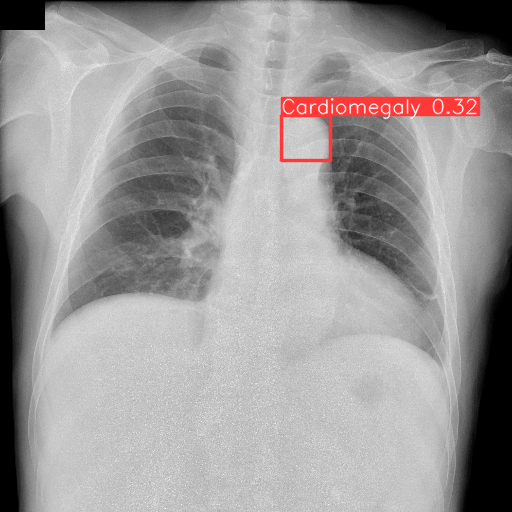

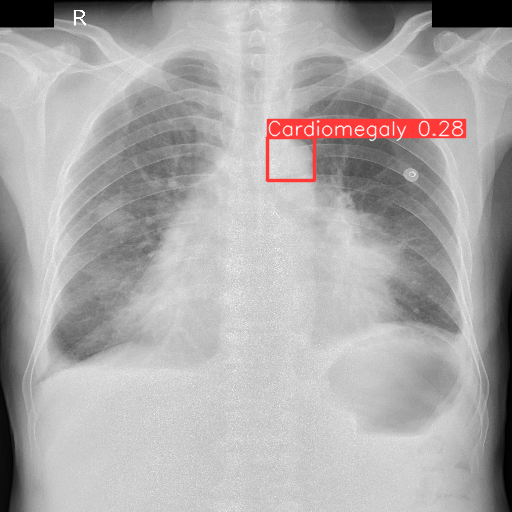

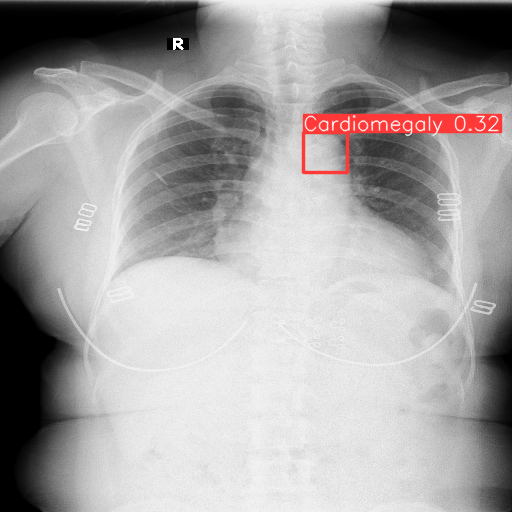

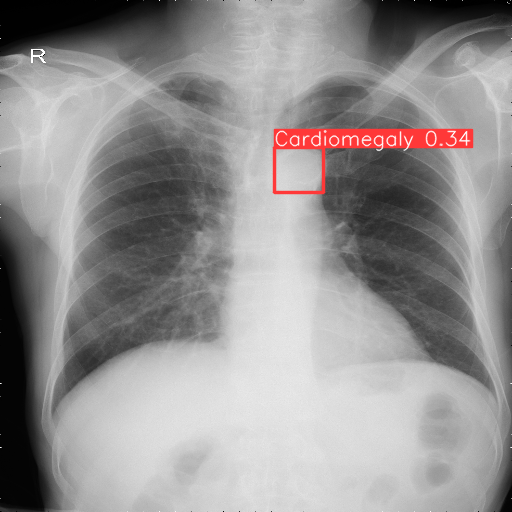

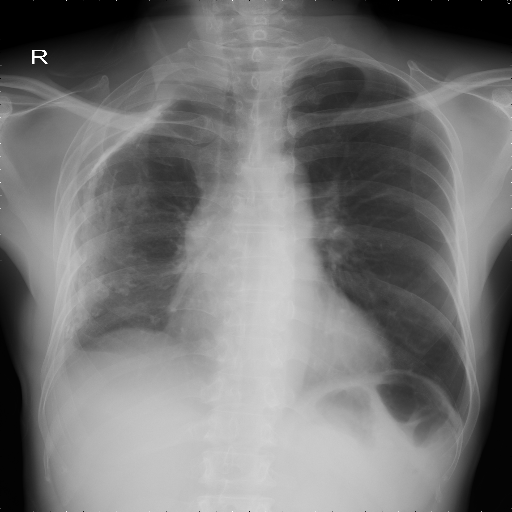

In [27]:
results = model(test_images)
results.show()